# Assignment 2

In this assignment, we will study DenseNet model and take a look under its hood.
As an ML practioner, you will have to read research papers quite often, so let's practice doing that.
This assignment requires familiarity with the DenseNet paper, so please read it before starting the first task.
This particular paper is very readable relative to some other ML papers out there.
When you go through the paper, please pay attention to the architecture of the network, because
that's where the novelty of this paper is originating from.

DenseNet was originally proposed in 2016 by Gao Huang, Zhuang Liu, Laurens van der Maaten, Kilian Q. Weinberger in the following paper:
https://arxiv.org/abs/1608.06993

# Task 1 = 5 points

Now that you know what DenseNet is all about, let's compare it to VGG.
Both VGG and DenseNet papers describe several variations of their models that differ by their depth.
For example, VGG16 and VGG19, DenseNet-121 and DenseNet-169 are four examples from these papers.
All of these models have different number of layers, so this difference is trivial.
If you need a refresher on VGG architecture, you can take a look at the lecture slides (which have everything you need to know about it for this assignment) or the VGG paper itself:
https://arxiv.org/abs/1409.1556

Aside from difference in network depth, how is the architecture of DenseNet different from that of VGG?

Please enter your answer in the next cell (approximately 100-200 words).

# Answer 1

DenseNet builds upon the architectural insight from ResNet. Skip connections proved useful for allowing gradient to flow through many layers of the network. Authors of DenseNet conjecture that summation is not an optimal way to recombine the skip connection with the activation volume of a convolutional layer. Authots propose to connect each layer directly to every subsequent layer through depth-wise concatenation of the activation volumes. In constrast, each VGG layer is only connected to its immediate neighbors.

Since networks typically reduce the spatial dimensions of the input through pooling, depth-wise concatenation is only possible for activation volumes with the same spatial dimensions. Authors propose to group several convolutional layers into a block. Within a block, all activations have the same spatial dimensions, and therefore can be depth-wise concatenated. After each block, a pooling layer reduces spatial dimensions, and its output is fed into the next block.

Although not an original concept, DenseNet employs 1x1 convolutions to compress the activation depth. This operation in effect takes a weighed average between activations of the same spatial location across depth. This increases computational efficiency of the network. Finally, another non-original concept is to use global average pooling as the layer immediately preceeding the fully connected classifier. This also increases the efficiency of the network, when compared to VGG.

# Task 2 = 5 points

Great job on the architectural analysis! Let's now take a look at what's happening in a pre-trained model.
Throughout this assignment, the tasks will be similar to visualizations that we saw in class during VGG demo.
You can refer to VGGDeepDream.ipynb, and copy code from there.

The task is to plot the filter with the following location:
* model - DenseNet-121
* operation - first convolutional (before the first dense block)
* input channel - all three RGB channels
* output channel - 42 (note that the first channel is 0)

Note that you will not get points for plotting all output channels, as was shown in DenseNetVisualization.ipynb.
Since the weight matrix is real-valued, you need to transform the weights into the $[0, 1]$ range before plotting.
In class, we saw one way to do that: rescaling weights to have std = 1, then applying sigmoid. See the code in utils.py file for an example of this transformation. You can use other methods too. When you submit the notebook, make sure the plot is saved with the notebook.

In [23]:
# Code 2
# Enter your code here. This is a Python cell.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet121

# Instead of using Keras API to feed image into the model,
# we need our own Variable tensor so we can use it directly.
# Note that this task does not require running the model,
# but the next two do require running it, so we will instantiate
# the model as required for the upcoming tasks right away.
# Note that we load the model without any fully connected layers,
# since we will not use this model as a classifier in this notebook.
input_tn = tf.Variable(np.empty([1, 224, 224, 3]), dtype='float32')
model = DenseNet121(input_tensor=input_tn, include_top=False, input_shape=(224, 224, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [2]:
# Note that we need to get Tenserflow session from Keras,
# because it's the only session where VGG16 is initialized
# with the pre-trained weights. New sessions have random initialization.
s = tf.keras.backend.get_session()

In [3]:
# Let's find all variables whose names start with conv/kernel.
# You can also remove this condition to view all variables.
conv_kernels = {w.name:w for w in model.weights if 'conv/kernel' in w.name}

# After inspecting the variable list,
# we can see that the required filter is located at:
kernel = conv_kernels['conv1/conv/kernel:0'][:, :, :, 42]
kernel = s.run(kernel)

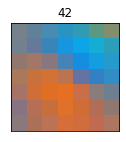

In [6]:
from utils import plot_conv_kernel
import matplotlib.pyplot as plt

plot_conv_kernel(kernel, labels=[42])
plt.show()

# Task 3 = 5 points

Now that you visualized the first layer, let's visualize some of the deeper layers.
Since plotting the deep filters directly is not useful, we can feed an image through the network,
and visualize an activation map instead.

The task is to plot an activation map in the following location:
* model - DenseNet-121
* operation - dense block 1, convolutional layer 3
* output channel - 42 (note that the first channel is 0)
* image - cat from the tiny batch, see example below

Since the activation map is real-valued, you need to transform the activations into the $[0, 1]$ range before plotting.
In class, we have seen one way to do that: rescaling activations to have std = 1, then applying sigmoid. See the code in utils.py file for an example of this transformation. You can use other methods too. When you submit the notebook, make sure the plot is saved with the notebook.

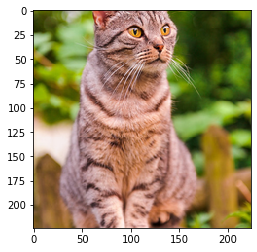

In [7]:
# Loading the image of a cat

from utils import load_tiny_batch, crop_and_resize_for_imagenet

cat_raw = load_tiny_batch()['cat']
cat_resized = np.array(crop_and_resize_for_imagenet(cat_raw))
cat_packaged = np.array(cat_resized, dtype='float32').reshape(1, 224, 224, 3)

# When you feed the model with an image, use cat_packaged variable,
# which is a 1x224x224x3 array of floats in the [0, 255] range.
# The model expects the input tensor to be of this shape and range.

plt.imshow(cat_packaged[0].astype(int))

In [8]:
# Enter your code here. This is a Python cell.

In [9]:
# In order to look at the activation map,
# we need to find the convolution operation first.
conv_ops = {op.name:op for op in s.graph.get_operations() if op.type == 'Conv2D' and 'conv2_' in op.name}

# After examining the list of operations,
# we can see that the task is asking to plot the following activation map:
activation_map_tn = s.graph.get_tensor_by_name('conv2_block2_1_conv/Conv2D:0')[0, :, :, 42]

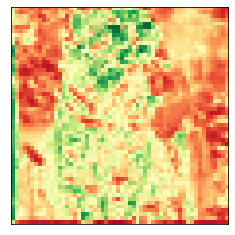

In [10]:
from utils import plot_activation_map

s.run(input_tn.assign(cat_packaged))
activation_map = s.run(activation_map_tn)
plot_activation_map(activation_map)

# Task 4 = 5 points

Amazing job so far! Now for the grand finale, let's put DenseNet to sleep and make it dream a bit.
Construct a training procedure to maximize average value of the activation map:
* model - DenseNet-121
* operation - dense block 2, convolutional layer 10
* output channel - 8 (note that the first channel is 0)
* initial image - cat from the tiny batch, see example below

Note that unlike in the previous tasks, there is no need to transform the image after training as long as you are clipping the pixel values to $[0, 255]$ range after each iteration, which you should do to prevent learning images with pixel values far outside the allowed range.

Adjust the learning rate and number of iterations so that the final image contains clearly visible artifacts without totally obscuring the cat. Apply some artistic feeling to this process :)

When you submit the notebook, make sure the image is saved with the notebook.

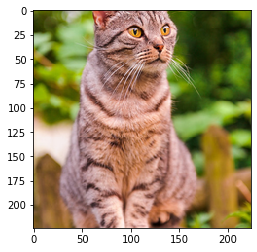

In [11]:
# Loading the image of a cat

from utils import load_tiny_batch, crop_and_resize_for_imagenet

cat_raw = load_tiny_batch()['cat']
cat_resized = np.array(crop_and_resize_for_imagenet(cat_raw))
cat_packaged = np.array(cat_resized, dtype='float32').reshape(1, 224, 224, 3)

# When you feed the model with an image, use cat_packaged variable,
# which is a 1x224x224x3 array of floats in the [0, 255] range.
# The model expects the input tensor to be of this shape and range.

plt.imshow(cat_packaged[0].astype(int))

In [12]:
# Enter your code here. This is a Python cell.

In [13]:
# In order to look at the activation map,
# we need to find the convolution operation first.
{op.name:op for op in s.graph.get_operations() if op.type == 'Conv2D' and 'conv3_' in op.name}

{'conv3_block1_1_conv/Conv2D': <tf.Operation 'conv3_block1_1_conv/Conv2D' type=Conv2D>,
 'conv3_block1_2_conv/Conv2D': <tf.Operation 'conv3_block1_2_conv/Conv2D' type=Conv2D>,
 'conv3_block2_1_conv/Conv2D': <tf.Operation 'conv3_block2_1_conv/Conv2D' type=Conv2D>,
 'conv3_block2_2_conv/Conv2D': <tf.Operation 'conv3_block2_2_conv/Conv2D' type=Conv2D>,
 'conv3_block3_1_conv/Conv2D': <tf.Operation 'conv3_block3_1_conv/Conv2D' type=Conv2D>,
 'conv3_block3_2_conv/Conv2D': <tf.Operation 'conv3_block3_2_conv/Conv2D' type=Conv2D>,
 'conv3_block4_1_conv/Conv2D': <tf.Operation 'conv3_block4_1_conv/Conv2D' type=Conv2D>,
 'conv3_block4_2_conv/Conv2D': <tf.Operation 'conv3_block4_2_conv/Conv2D' type=Conv2D>,
 'conv3_block5_1_conv/Conv2D': <tf.Operation 'conv3_block5_1_conv/Conv2D' type=Conv2D>,
 'conv3_block5_2_conv/Conv2D': <tf.Operation 'conv3_block5_2_conv/Conv2D' type=Conv2D>,
 'conv3_block6_1_conv/Conv2D': <tf.Operation 'conv3_block6_1_conv/Conv2D' type=Conv2D>,
 'conv3_block6_2_conv/Conv2D': <

In [14]:
# After examining the list of operations,
# we can see that the task is asking to maximize the following activation map:
activation_map_tn = s.graph.get_tensor_by_name('conv3_block5_2_conv/Conv2D:0')[0, :, :, 8]

# Let's construct the gradient with respect to the image.
cost_tn = -tf.reduce_mean(activation_map_tn)
gradient_op = tf.gradients(cost_tn, input_tn)

# Finally, a training iteration is a simple gradient descent.
# The learning rate needs to be pretty high for visible artifacts.
learning_rate = 6000000
new_image_tn = input_tn - learning_rate * gradient_op[0]
new_image_tn = tf.clip_by_value(new_image_tn, 0, 255)

In [15]:
image_current = cat_packaged
for i in range(30):
    s.run(input_tn.assign(image_current))
    image_current = s.run(new_image_tn)

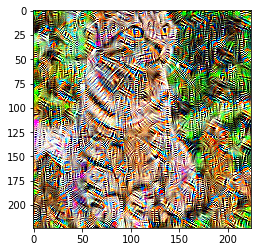

In [16]:
plt.imshow(image_current[0].astype(int))